# Global Sensitivity Analysis (GSA)

Sensitivity methods we've looked at so far only evaluate the "local" sensitivity at a single set of parameter values.  For example, the Jacobian matrix represents perturbations to a single set of parameter values.  This local view can be a problem in cases when our inverse problem is nonlinear, which means the parameter sensitivities can change depending on what the parameter value is. In contrast, Global Sensitivity Analyses are statistical approaches that characterize how model parameters affect model outputs over a __wide range__ of acceptable parameter values. Because we often test a number of parameter sets during parameter estimation, GSA methods provide a more robust view of parameter sensitivity compared to traditional, derivative-based local sensitivity analysis. Some GSA methods provide general information about the variability of the sensitivities and have relatively low computational requirements, whereas others provide detailed information on nonlinear behavior and interactions between parameters at the expense of larger computational requirements. For a complete introduction to GSA theory and methods, see Saltelli and others (2004, 2008).

### Local Sensitivity Equation
Recall the local sensitivity equation (eq. 9.7 Anderson et al. 2015):

<img src="Sensitivity_eq.png" style="float: center">

In GSA the change in parameter is not just small perturbations (usually 1%) around the parameter value but rather spans the reasonable parameter range.  What is a reasonable range?  For convenience GSA++ uses the parameter bounds that you specify in your PEST Control File.

Anothe way to look at this finite-difference approximation is:

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

### But we only do this around one set of parameter values.  What if we looked at more than one set of parameters?

### That's what GSA does, but lots of parameters evaluated = lots of computer time.  Luckily we can use the PEST++ engine to run GSA in parallel

GSA++ is a stand-alone program distributed with the PEST++ Version 3 suite of tools that perform GSA. It leverages the PEST++ parallel run manger YAMR, and is fully compatible with PEST/PEST++ file formats, including template and instruction files. For us this means we can access the insight of GSA using parallel computing without changing our files. More GSA++ running details are provided in appendix 6 of the PEST++ V3 Techniques and Methods Report. Appendixes 7 and 8 demonstrate the use of GSA++ for a Method of Morris and Sobol example problem.  In this notebook we'll run GSA on the Freyburg model.

### Brief take on GSA Theory from the PEST++ T&M Report (Welter et al. 2015 pages 5-7):

The program GSA++ currently supports two GSA methods: (1) the __Method of Morris__ (Morris, 1991), and (2) the __Method of Sobol__ (Sobol, 2001). In the class we'll focus on the Method of Morris because it is computationally more efficient. But this efficiency comes with a tradeoff: the Method of Morris only provides estimates of the mean and variance of the sensitivity distribution for each parameter. Because of the lack of complete description of the parameter nonlinearity and interactions between parameters, the Method of Morris can be used as a screening-level tool to identify the most important parameters for the observations tested. This screening can be followed by application of a more comprehensive tool, such as the Method of Sobol, which further characterizes the effects of parameter nonlinearity and inter-parameter interactions. 

The Method of Morris is referred to as a “one-at-a-time” method because each parameter is perturbed sequentially to compute sensitivities, which is ideally suited for parallel computing. The method samples the sensitivity of a given parameter at several locations over the range of reasonable parameter space (__defined by the parameter bounds in the PEST Control file__) and then provides two measures of parameter sensitivity: the mean (__μ__) and the standard deviation (__σ__) of the resulting sensitivity distribution. The mean, __μ__, captures the overall effect of a parameter on the model output of interest; the standard deviation, __σ__, measures a parameter’s sensitivity across the range of acceptable parameter values, this being an indicator of how nonlinear a given parameter is and (or) how the parameter interacts with other parameters. It is important to note that the Method of Morris __cannot distinguish__ between parameter nonlinearity and parameter interactions because only the standard deviation of parameter sensitivity is available. 

#### For the class we'll focus on the easiest way to get in the GSA game using pyemu, but this is also likely what you would start with in 95% of the models you evaluate.  For convenience, widely applicable default values are supplied for you by pyemu but can easily be changed by editing the *.gsa* file pyemu creates  (see Appendix 6 in the PEST++ V3 report for descriptions of the *.gsa* variables). 

### The objectives of this notebook are:

1) to calculate local sensitivities for the Freyberg zone model and evaluate them

2) look at the Method of Morris GSA results for the same parameters

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
working_dir = os.path.join('freyberg_mf6')
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
shutil.copytree(org_d,working_dir)
# get executables
hbd.prep_bins(working_dir)
# get dependency folders
hbd.prep_deps(working_dir)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(working_dir)
# convenience function that builds a new control file with pilot point parameters for hk
hbd.add_ppoints(working_dir)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:1, nnz_obs:24
written pest control file: freyberg_mf6\freyberg.pst
   could not remove start_datetime
1 pars added from template file .\freyberg6.sfr_perioddata_1.txt.tpl
6 pars added from template file .\freyberg6.wel_stress_period_data_10.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_11.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_12.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_2.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_3.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_4.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_5.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_6.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_7.txt.tpl
0 pars added from template file .\freyberg6.wel_s

#### Let's double check what parameters we have in this version of the model using pyemu (you can just look in the PEST control file too....)

In [3]:
pst_name = "freyberg_pp.pst"

pst = pyemu.Pst(os.path.join(working_dir,pst_name))

#update paramter transform
par = pst.parameter_data
#par.loc['rch0', 'partrans'] = 'log'
par.loc['rch1', 'partrans'] = 'log'
#par.loc[par.pargp=='rchpp', 'partrans'] = 'fixed'
#par.loc[par.pargp=='strinf', 'partrans'] = 'fixed'
#par.loc[par.pargp=='wel', 'partrans'] = 'fixed'
# write
pst.write(os.path.join(working_dir, pst_name))

pst.parameter_data

noptmax:0, npar_adj:66, nnz_obs:37


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra,i,j,zone
parnme,,,,,,,,,,,,,,
ne1,ne1,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN,NaN,NaN,NaN
rch0,rch0,fixed,factor,1.00,0.500,2.00,rch0,1.0,0.0,1,NaN,NaN,NaN,NaN
rch1,rch1,log,factor,1.00,0.500,2.00,rch1,1.0,0.0,1,NaN,NaN,NaN,NaN
strinf,strinf,log,factor,500.00,50.000,5000.00,strinf,1.0,0.0,1,NaN,NaN,NaN,NaN
wel5,wel5,log,factor,300.00,10.000,900.00,wel,-1.0,0.0,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rch_i:32_j:17_zone:1.0,rch_i:32_j:17_zone:1.0,log,factor,1.00,0.500,2.00,rchpp,1.0,0.0,1,NaN,32,17,1.0
rch_i:27_j:17_zone:1.0,rch_i:27_j:17_zone:1.0,log,factor,1.00,0.500,2.00,rchpp,1.0,0.0,1,NaN,27,17,1.0
rch_i:17_j:2_zone:1.0,rch_i:17_j:2_zone:1.0,log,factor,1.00,0.500,2.00,rchpp,1.0,0.0,1,NaN,17,2,1.0


In practice, correlation >0.95 or so becomes a problem for the parameter estimation problem.  

# 2. Global Sensitivity
### Secondly, let's run GSA, a global sensitivity analysis tool.  By default (no extra settings), GSA will run the Method of Morris with 4 discretization points for each parameter (36 runs) plus the 4 new starting points from the intial conditions (4 runs). That is, 44 runs instead of the 11 needed for the local sensitivity method, so we'll use sweep.

In [15]:
pyemu.os_utils.start_workers(working_dir, # the folder which contains the "template" PEST dataset
                            'pestpp-sen', #the PEST software version we want to run
                            pst_name, # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

#### Again, let's echo out the working directory in case you want to look at the files that were just created...

In [16]:
os.getcwd()

'd:\\Workspace\\hugm0001\\github\\GMDSI_notebooks_fork\\tutorials\\part1_xx3_global_sensitivity'

## GSA results

Let's look at a table and plot of the GSA results.  In this case we are looking at the mean sensitivity, and the standard deviation of the sensitivity as you change the starting value in the parameter space.  

> If the __mean sensitivity is high__ it shows that parameter has higher sensitivity across the parameter space.  

>If the __standard deviation is low__, then the linear assumptions of FOSM hold (that is, the sensitivity is the similar regardless of starting value).  

In [17]:
df = pd.read_csv(os.path.join(m_d,pst_name.replace(".pst",".msn")),skipinitialspace=True)
df.loc[:,"parnme"] = df.pop("parameter_name").apply(lambda x : x.lower().replace("log(",'').replace(')',''))
df.index = df.parnme
df.head()

,n_samples,sen_mean,sen_mean_abs,sen_std_dev,parnme
parnme,,,,,
rch1,4,0.000,0.000,0.000,rch1
strinf,4,405.552,4934.630,7635.800,strinf
wel5,4,-553.984,553.984,884.045,wel5
wel2,4,-276.242,692.051,1137.280,wel2
wel4,4,127.936,127.936,139.486,wel4


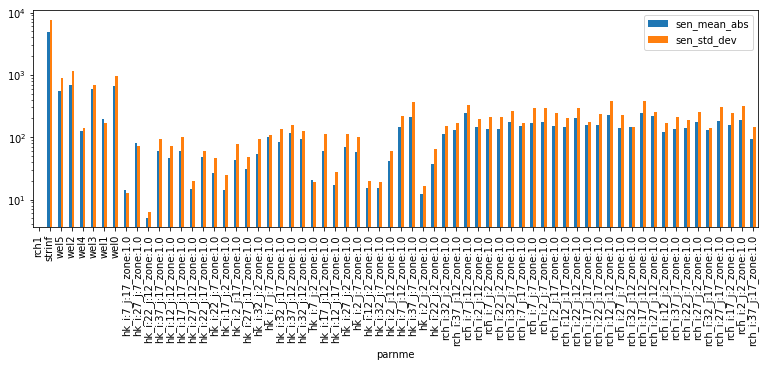

In [41]:
df.loc[:,["sen_mean_abs","sen_std_dev"]].plot(kind="bar", figsize=(13,4))
plt.yscale('log');

### Interesting!  ``hk_z03`` is more sensitive across parameter space compared to the other HK parameters but hk_z02 is similar (hmm, weren't these two correlated above?)...and it and ``rch_0`` looks to be suffering from non-linearity (and/or interactions with other parameters - Method of Morris can't distinguish the two)!

<AxesSubplot:>

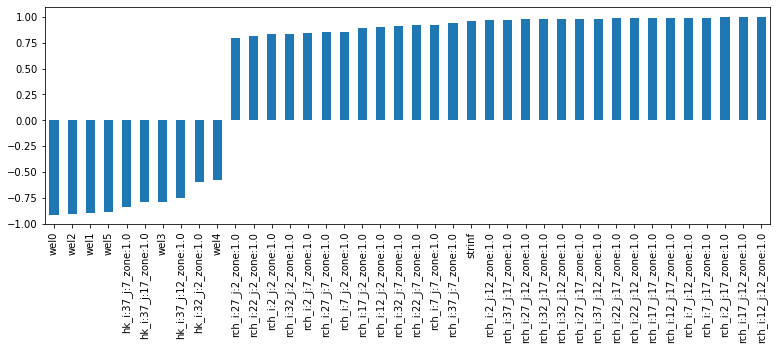

In [42]:
cpar = 'rch_i:12_j:12_zone:1.0'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5].sort_values().plot(kind='bar', figsize=(13,4))

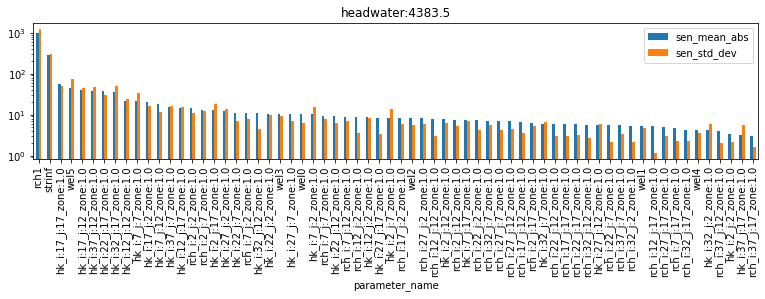

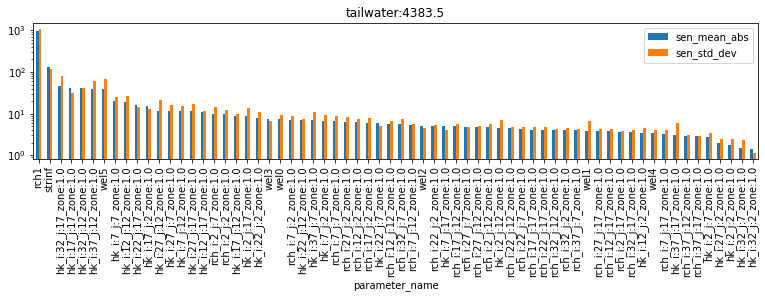

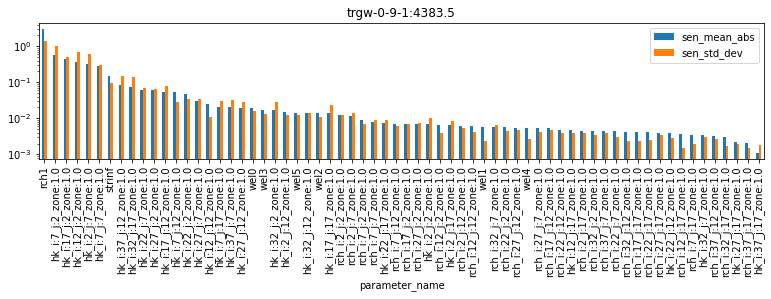

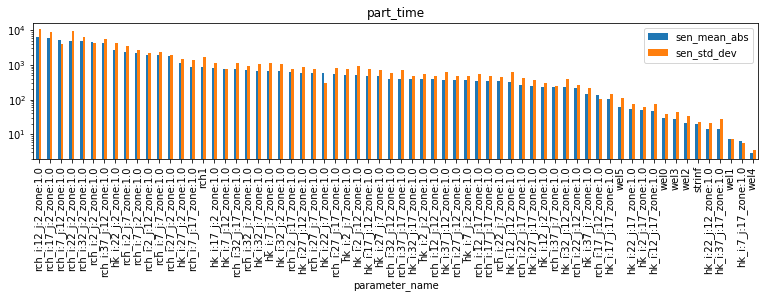

In [59]:
df_pred_sen = pd.read_csv(os.path.join(m_d,pst_name.replace(".pst",".mio")),skipinitialspace=True)

for forecast in pst.forecast_names:
    tmp_df = df_pred_sen.loc[df_pred_sen.observation_name==forecast].sort_values(by='sen_mean_abs', ascending=False)
    #tmp_df.plot(x='parameter_name',y='sen_mean_abs', kind='bar')
    tmp_df.plot(x="parameter_name",y=["sen_mean_abs","sen_std_dev"],kind="bar", figsize=(13,2.5))
    plt.title(forecast)
    plt.yscale('log');